In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipynb

import sys 
import os
sys.path.append(os.getcwd())
from ipynb.fs.full.preprocessing_pk import *
from ipynb.fs.full.clustering_pk import *

# Expand displayed data rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')

In [48]:
def q10(x):
    return x.quantile(0.1)
def q90(x):
    return x.quantile(0.9)

## Basic Clearning

In [3]:
# convert the account_id from num to str
df1=df_raw.copy()
df1['account_id']=df1['account_id'].astype('str')

In [4]:
# convert data/time from str to date/time
dt_stamps=df1.filter(regex='date$|time$', axis=1).columns
df1[dt_stamps]=df1[dt_stamps].apply(pd.to_datetime, errors='coerce')

In [5]:
# delete the duplicates
df1=df1.drop_duplicates()

In [6]:
# parse the address column into 3 columns: street, state, country
df1 = df1.join(df1.address.str.split(',', expand=True)).rename(columns={0:'street',1:'state', 2:'country'})

In [7]:
# get the length in months between each date and the most recent date
latest_month=df1['max_bill_date'].dt.to_period('M').astype(int).max()

## recency: MONTHDIFF(current_month:2021-04, max_bill_date)
df1['recency_months']=months_diff(df1, 'max_bill_date', latest_month)

## account length: MONTHDIFF(current_month:2021-04, account_created_time )
df1['account_length_months']=months_diff(df1, 'account_created_time', latest_month)

## first purchase length: MONTHDIFF(current_month:2021-04, sticky_bill_date)
df1['first_bill_months']=months_diff(df1, 'min_bill_date', latest_month)   

## activated length: MONTHDIFF(current_month:2021-04, first_activated_time)
df1['activated_length_months']=months_diff(df1, 'first_activated_time', latest_month)
                                           
## sticky length: MONTHDIFF(current_month:2021-04, sticky_bill_date)
df1['sticky_length_months']= months_diff(df1, 'sticky_bill_date', latest_month) 

## Features Relationhips

Text(0.5, 1.0, 'Marketing Campaign Responses Count (reponse rate: 0.56)')

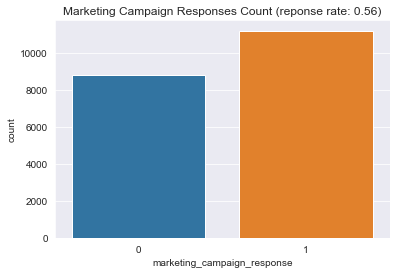

In [8]:
# Overall conversion
reponse_rate=round(len(df1[df1['marketing_campaign_response']==1])/len(df1), 2)
sns.countplot(x='marketing_campaign_response', data=df1)
plt.title(f'Marketing Campaign Responses Count (reponse rate: {reponse_rate})' )

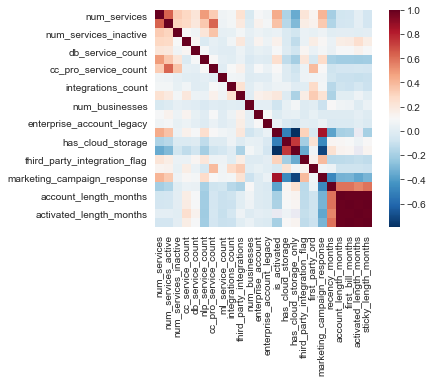

In [9]:
## Visualize feature correlations
sns.heatmap(df1._get_numeric_data().astype(float).corr(),
            square=True, cmap='RdBu_r', #linewidths=.1,
            annot=False #, fmt='.2f'
           )
plt.show()

In [10]:
## Investigate the correlations between dependent and independent variables
df1.corr(method='pearson').loc['marketing_campaign_response'].sort_values(ascending=False)

marketing_campaign_response     1.000000
is_activated                    0.848571
num_services                    0.405876
third_party_integration_flag    0.386497
num_services_active             0.336868
nlp_service_count               0.263835
third_party_integrations        0.233669
cc_service_count                0.114844
cc_pro_service_count            0.107035
db_service_count                0.083297
integrations_count              0.076098
ml_service_count                0.070687
first_party_ord                 0.070311
num_services_inactive           0.054638
enterprise_account_legacy       0.040954
enterprise_account             -0.013982
num_businesses                 -0.089465
first_bill_months              -0.314914
sticky_length_months           -0.317962
account_length_months          -0.324249
activated_length_months        -0.363026
has_cloud_storage              -0.468048
recency_months                 -0.475744
has_cloud_storage_only         -0.720397
Name: marketing_

## Segmentation

In [40]:
# def cluster_params_sse(df, feature, max_clusters):
#     sse={}
#     var=df[[feature]]
#     for k in range(1, max_clusters):
#         kmeans=KMeans(n_clusters=k, max_iter=1000).fit(var)
#         sse[k]=kmeans.inertia_
#     return sse

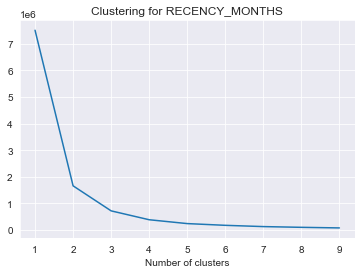

In [41]:
from ipynb.fs.full.clustering import *

## Recency Cluster
recency_cluster_sse=cluster_params_sse(df1, 'recency_months', 10)
plot_nclusters_sse(recency_cluster_sse, 'recency_months')

In [42]:
df_c=create_cluster_label(df1, 'recency_months', 3, False)

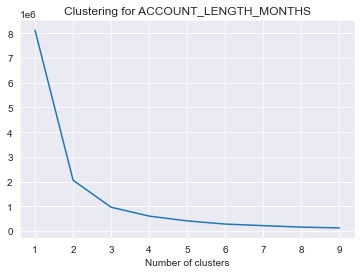

In [43]:
## Account Length Cluster
alength_cluster_sse=cluster_params_sse(df_c, 'account_length_months', 10)
plot_nclusters_sse(alength_cluster_sse, 'account_length_months')

In [44]:
df_c=create_cluster_label(df_c, 'account_length_months', 3, False)

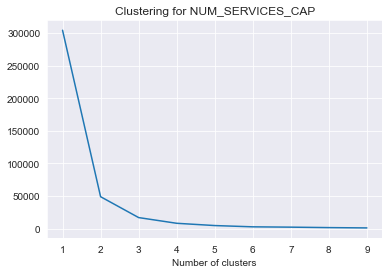

In [45]:
## Services Cluster
df_c['num_services_cap']=df_c['num_services'].where(df_c['num_services']<=df_c['num_services'].quantile(0.9),
                                                       df_c['num_services'].quantile(0.9))
services_cluster_sse=cluster_params_sse(df_c, 'num_services_cap', 10)
plot_nclusters_sse(services_cluster_sse, 'num_services_cap')

In [46]:
df_c=create_cluster_label(df_c, 'num_services_cap', 3, True)

### Combine Three dimensions to segment accounts

In [47]:
df_c['clusters_score']=df_c['recency_months_cluster']+df_c['num_services_cap_cluster']+df_c['account_length_months_cluster']

In [49]:
df_c.groupby(['clusters_score']).agg({'recency_months':['mean','min',q90]
                                      , 'account_length_months':['mean','min',q90]
                                      , 'num_services':['mean','min',q90]
                                      , 'marketing_campaign_response':['mean','count']})

recency_months         account_length_months          \
                         mean min q90                  mean min q90   
clusters_score                                                        
0                   54.124399  40  65             62.458623  52  73   
1                   38.596346  16  54             57.044850  39  69   
2                   26.565327   0  49             49.882316  29  67   
3                   13.862697   0  30             41.406305  15  64   
4                    6.997184   0  18             29.361490   3  59   
5                    3.855637   0  13             25.109550   3  44   
6                    2.369574   0   7             15.780211   3  25   

               num_services         marketing_campaign_response        
                       mean min q90                        mean count  
clusters_score                                                         
0                  0.138815   0   0                    0.046450  1873  
1                  0.948505   0   4                    0.136213  1806  
2                  2.032268   0   8                    0.258146  3161  
3                  2.966025   0   7                    0.487566  2855  
4                  4.773229   0  10                    0.655187  4617  
5                  8.622485   3  16                    0.984350  3131  
6                 13.193586   7  21                    0.996089  2557

In [50]:
df_c.groupby(['clusters_score']).agg({'recency_months':['mean']
                                      , 'account_length_months':['mean']
                                      , 'num_services':['mean']
                                      , 'marketing_campaign_response':['mean','count']})

recency_months account_length_months num_services  \
                         mean                  mean         mean   
clusters_score                                                     
0                   54.124399             62.458623     0.138815   
1                   38.596346             57.044850     0.948505   
2                   26.565327             49.882316     2.032268   
3                   13.862697             41.406305     2.966025   
4                    6.997184             29.361490     4.773229   
5                    3.855637             25.109550     8.622485   
6                    2.369574             15.780211    13.193586   

               marketing_campaign_response        
                                      mean count  
clusters_score                                    
0                                 0.046450  1873  
1                                 0.136213  1806  
2                                 0.258146  3161  
3                                 0.487566  2855  
4                                 0.655187  4617  
5                                 0.984350  3131  
6                                 0.996089  2557

In [51]:
## Segments
df_c['segment']='low'
df_c.loc[df_c['clusters_score']>=3, 'segment']='medium'
df_c.loc[df_c['clusters_score']>=5, 'segment']='high'

df_c.groupby(['segment'])['marketing_campaign_response'].agg({'mean', 'count'})

,mean,count
segment,,
high,0.989627,5688
low,0.167982,6840
medium,0.591140,7472


<AxesSubplot:xlabel='recency_months', ylabel='num_services'>

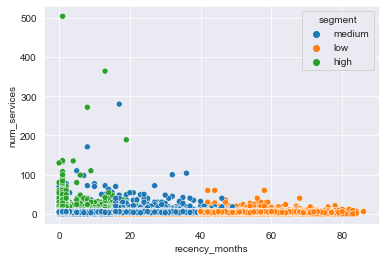

In [52]:
sns.scatterplot(data=df_c, y='num_services', x='recency_months', hue='segment')

## Exploration by vraible buckets

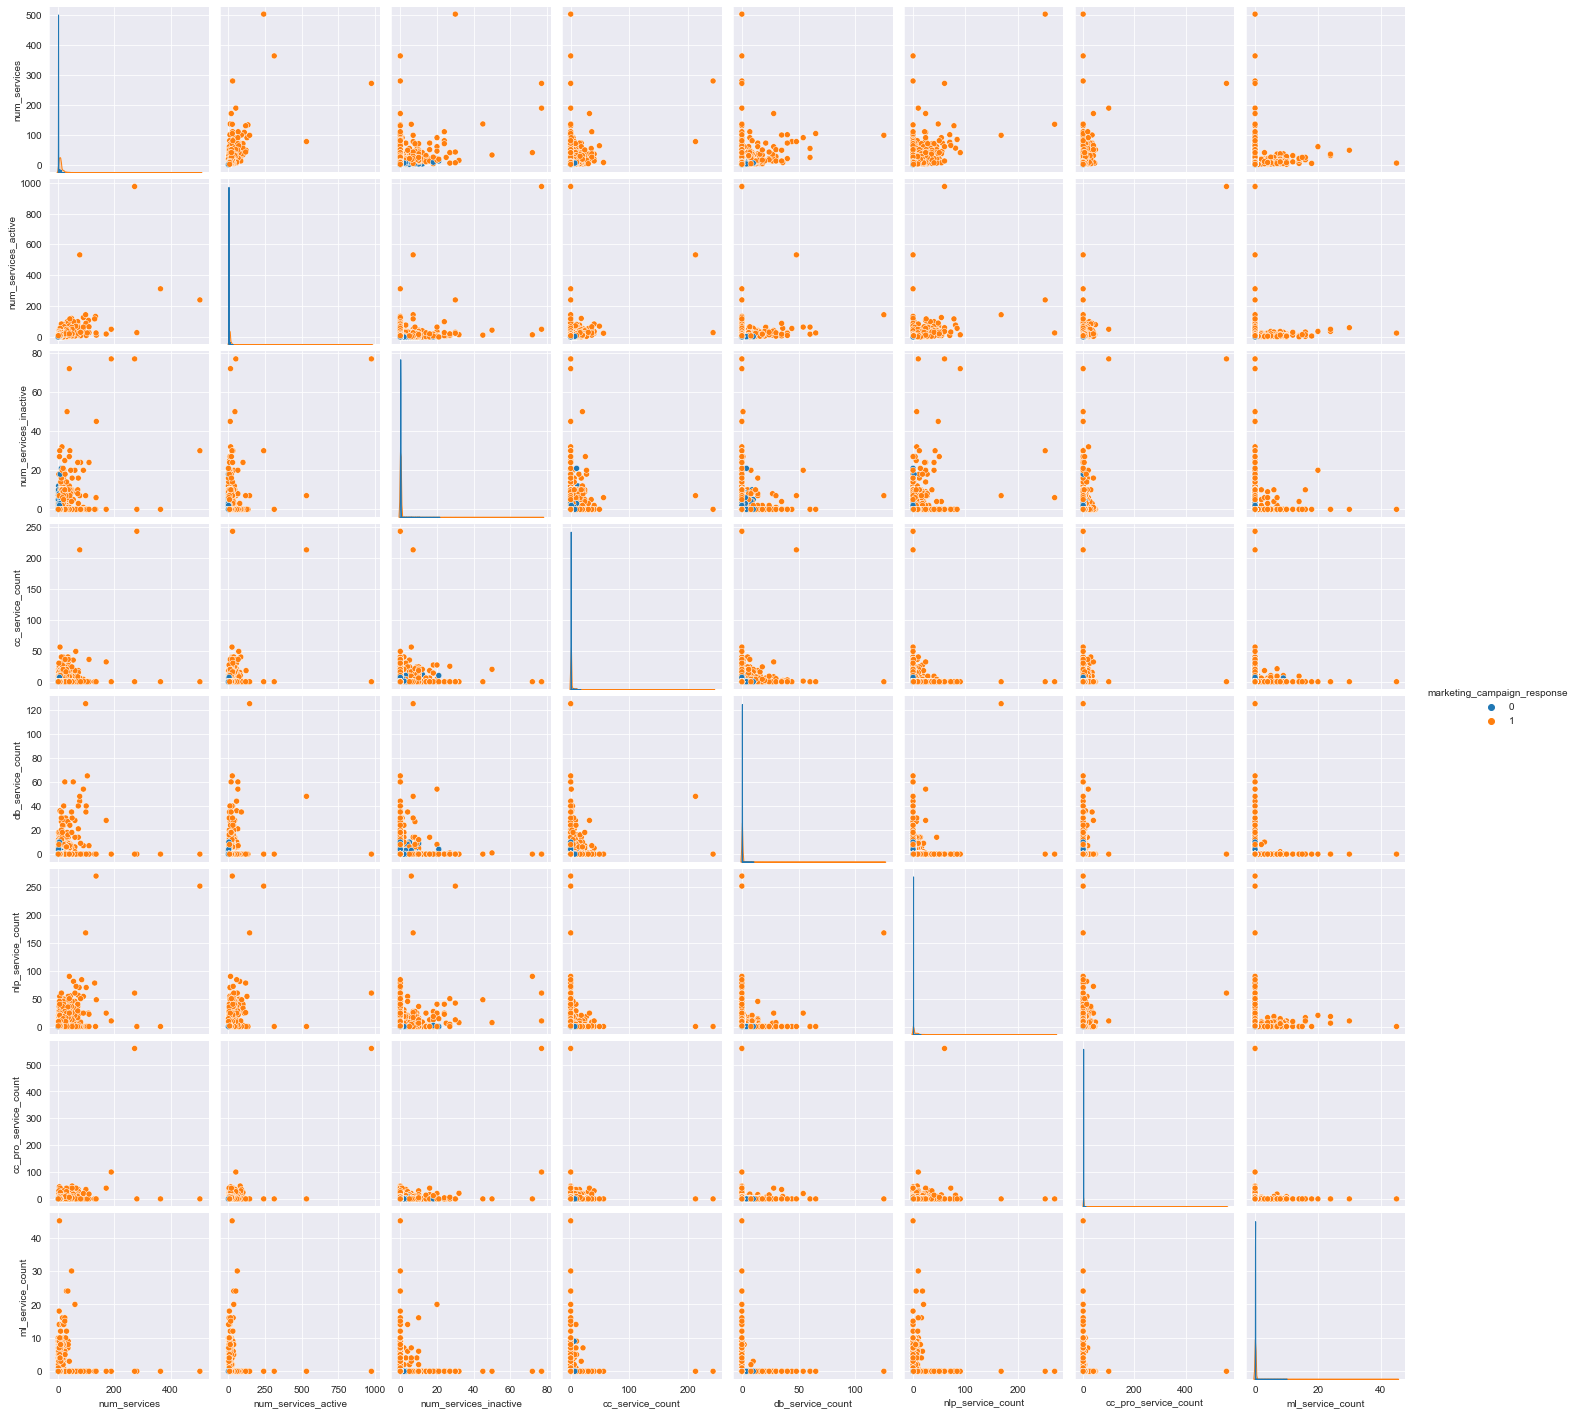

In [13]:
service_vars=df1.filter(regex='service').columns
sns.pairplot(data=df1, vars=service_vars, hue='marketing_campaign_response')

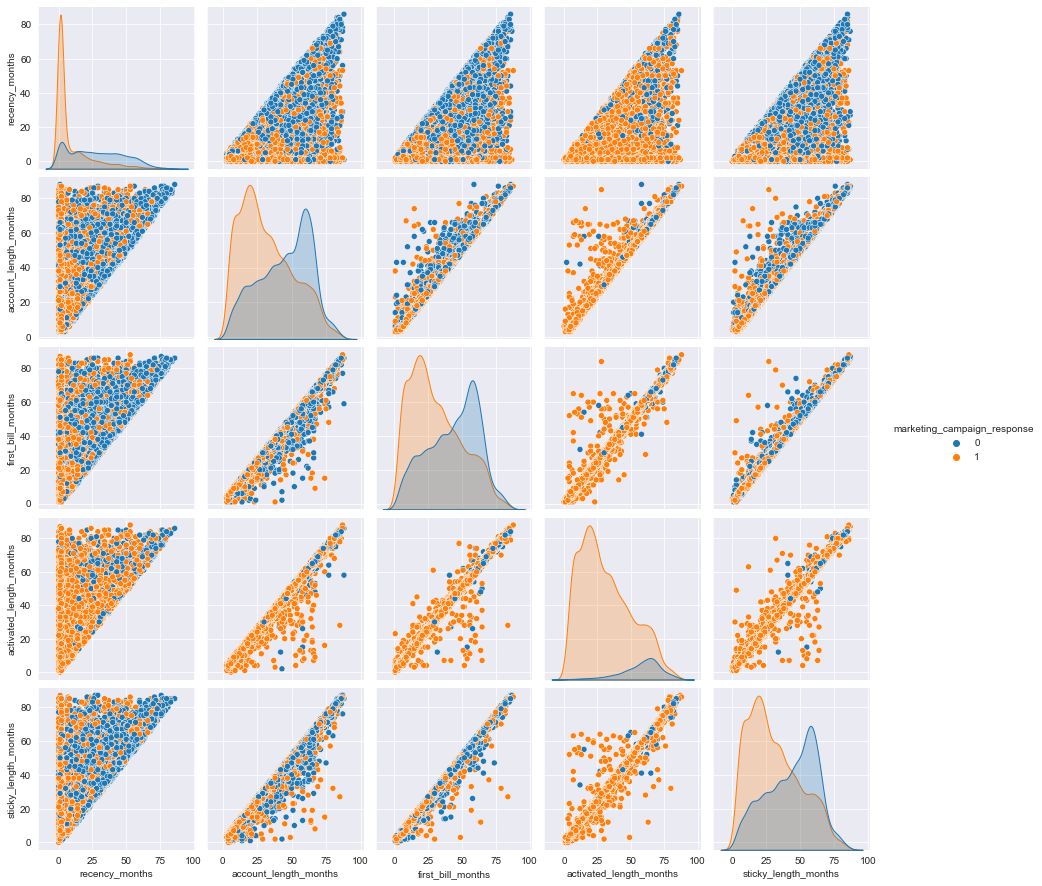

In [14]:
nvars=df1.filter(regex='month').columns
sns.pairplot(data=df1, vars=nvars, hue='marketing_campaign_response')

In [54]:
df1.groupby(['state'])['marketing_campaign_response'].agg({'mean','count'}).sort_values(by='count', ascending=False)[:10]

,mean,count
state,,
CA,0.536517,2848
FL,0.516908,2484
TX,0.532152,1975
NY,0.555447,1019
NJ,0.593915,756
GA,0.521390,748
OH,0.522070,657
PA,0.592767,636
NC,0.490998,611


### Input file for Modeling

In [38]:
df_c.to_csv('model_input.csv', index=False)